# Train RKT Model
This notebook will develop and train a neural network to predict the percent change in the RKT price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tickr = 'RKT'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on 4 GPUs!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,5.000129,-1.826549,1.332823,-0.917044,4.213352,0.267529,0.872261,0.201760,14.835805,0.942542,...,55.692308,65.277778,141.922078,110.654545,0.175300,0.162646,0.222542,0.110524,0.258319,0.332025
2021-03-02,9.343908,1.863776,4.042164,2.934554,174.755251,1.466274,7.879377,1.707536,451.967339,0.942542,...,114.076923,175.833333,240.753247,207.436364,0.181961,0.123451,0.279574,0.317875,0.181865,0.350776
2021-03-03,-6.182329,-0.098659,2.752170,1.314918,85.755179,0.537029,-1.440297,1.597079,348.202021,-2.989676,...,23.769231,46.333333,30.441558,38.654545,0.426540,-0.027270,0.430193,0.695704,-0.032957,0.464776
2021-03-04,-0.098927,-0.474546,2.263712,1.135171,71.436094,0.330193,-7.028348,0.273109,-101.854034,-3.322424,...,8.538462,10.166667,4.857143,9.418182,0.575626,-0.119200,0.522090,0.737085,-0.166349,0.638104
2021-03-05,-2.524424,-0.582888,2.009106,1.119711,59.577503,0.249310,-4.934956,-0.595337,-8.390460,-3.831674,...,2.692308,2.666667,5.883117,3.127273,0.377778,0.119990,0.223362,0.126367,0.283775,0.062601
2021-03-08,0.274855,-0.776161,1.799419,0.978161,50.750715,0.189559,0.310869,-0.549881,-4.511742,-3.944519,...,2.923077,8.611111,3.220779,3.509091,0.592424,-0.012290,0.355556,1.140347,-0.094057,0.188120
2021-03-09,0.552312,-0.813655,2.031279,0.966417,44.143936,0.263580,-0.240380,-0.535265,1.030907,-3.944519,...,3.538462,3.000000,2.168831,4.836364,0.525076,-0.134521,0.561060,0.327319,-0.175598,0.685220
2021-03-10,1.073096,-1.065370,2.342297,0.882411,38.343016,0.342698,1.626315,-0.139885,3.079404,-3.944519,...,3.230769,8.111111,5.805195,3.909091,0.622145,0.095265,0.183994,0.812993,0.152440,0.115266
2021-03-11,-0.632818,-1.237632,2.218276,0.799099,32.794008,0.291328,-0.193498,-0.236548,1.256845,-3.977582,...,1.384615,3.611111,0.792208,0.927273,1.045402,-0.130886,0.392337,1.398222,-0.121031,0.104615


In [8]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [400]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 0m 28s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 10 |periods: 20|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 11 |periods: 40|hidden: 50|layers: 2|drop: 0.

Training complete in 0m 2s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 89 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 90 |periods: 60|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 91 |periods: 1|hidden: 10|layer

Training complete in 0m 3s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 4s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 2s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 2s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 4s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 5s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 6s
Iteration: 169 |periods: 1|hidden: 50|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 2s
Iteration: 170 |periods: 5|hidden: 50|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 2s
Iteration: 171 |periods: 10|hidden: 50|l

Training complete in 0m 2s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 2s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 5s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 7s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 2s
Iteration: 248 |periods: 5|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 249 |periods: 10|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 250 |periods: 20|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 4s
Iteration: 251 |periods: 40|hidden: 

Training complete in 0m 3s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 4s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 6s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 326 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 327 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 328 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 329 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 330 |periods: 60|hidden: 10|l

Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 4s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 405 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 406 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 407 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 408 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 4s
Iteration: 409 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.01|clip: 5

Training complete in 0m 2s
Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 4s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 2s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 2s
Iteration: 483 |periods: 10|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 2s
Iteration: 484 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 2s
Iteration: 485 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 486 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 4s
Iteration: 487 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 2s
Iteration: 488 |

Training complete in 0m 3s
Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 561 |periods: 10|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 562 |periods: 20|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 563 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 564 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 7s
Iteration: 565 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 566 |periods: 5|hidden: 50|

Training complete in 0m 5s
Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 6s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 639 |periods: 10|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 640 |periods: 20|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 641 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 642 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 6s
Iteration: 643 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 644 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 645 |periods: 10|hidden: 100

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

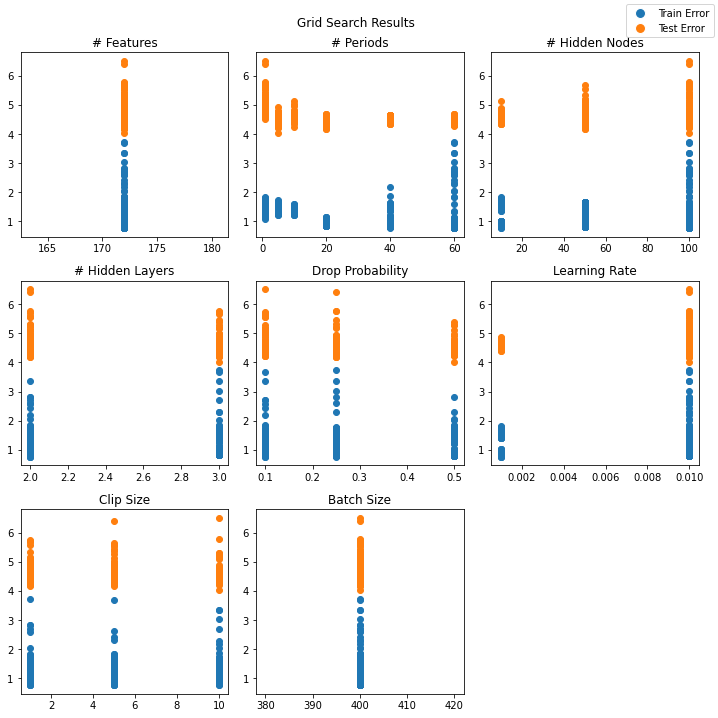

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
643,1.350058,4.027349,172.0,5.0,100.0,3.0,0.50,0.01,10.0,400.0
153,0.868512,4.169147,172.0,20.0,50.0,2.0,0.25,0.01,1.0,400.0
369,0.843721,4.182038,172.0,20.0,50.0,2.0,0.25,0.01,5.0,400.0
177,1.008276,4.201954,172.0,20.0,100.0,3.0,0.25,0.01,1.0,400.0
565,1.313466,4.206606,172.0,5.0,50.0,3.0,0.10,0.01,10.0,400.0
...,...,...,...,...,...,...,...,...,...,...
138,1.327503,5.724653,172.0,1.0,100.0,3.0,0.10,0.01,1.0,400.0
174,1.364828,5.751564,172.0,1.0,100.0,3.0,0.25,0.01,1.0,400.0
588,1.230339,5.766448,172.0,1.0,100.0,2.0,0.25,0.01,10.0,400.0
372,1.179486,6.399121,172.0,1.0,100.0,2.0,0.25,0.01,5.0,400.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 100, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

In [17]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
#batch_size = [1,5,10,20,40,60,120,240]
batch_size = [4,20,40,80,240,480,960]
epochs = [10,25,50,100,250,500]

In [18]:
# use fine grid search to optimize hyperparameters
fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 42 different configurations.
Iteration: 1 |epochs: 10|periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 0m 48s
Iteration: 2 |epochs: 10|periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 12s
Iteration: 3 |epochs: 10|periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 7s
Iteration: 4 |epochs: 10|periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 5 |epochs: 10|periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 6 |epochs: 10|periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 7 |epochs: 10|periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 8 |epochs: 25|periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 2m 5s
Iteration: 9 |epochs: 25|periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 28s
Iteration: 10 |epochs: 25|periods: 5|hidden: 100|layers: 3|drop: 0

In [19]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

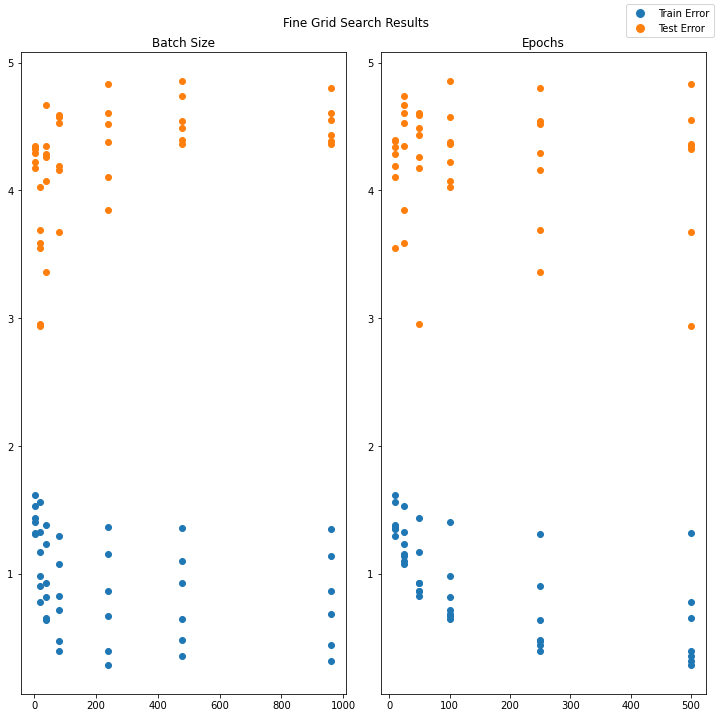

In [20]:
dh.visualizeFineGridSearch(fine_grid_result)

In [21]:
resultdf = dh.resultDFFine(fine_grid_result)

In [22]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
36,0.778094,2.939989,172.0,5.0,100.0,3.0,0.5,0.01,10.0,20.0,500.0
15,1.167855,2.952134,172.0,5.0,100.0,3.0,0.5,0.01,10.0,20.0,50.0
30,0.639474,3.362779,172.0,5.0,100.0,3.0,0.5,0.01,10.0,40.0,250.0
1,1.563517,3.552607,172.0,5.0,100.0,3.0,0.5,0.01,10.0,20.0,10.0
8,1.322504,3.586025,172.0,5.0,100.0,3.0,0.5,0.01,10.0,20.0,25.0
38,0.394965,3.672243,172.0,5.0,100.0,3.0,0.5,0.01,10.0,80.0,500.0
29,0.906264,3.693533,172.0,5.0,100.0,3.0,0.5,0.01,10.0,20.0,250.0
11,1.150486,3.849821,172.0,5.0,100.0,3.0,0.5,0.01,10.0,240.0,25.0
22,0.979500,4.028278,172.0,5.0,100.0,3.0,0.5,0.01,10.0,20.0,100.0
23,0.821138,4.072526,172.0,5.0,100.0,3.0,0.5,0.01,10.0,40.0,100.0


## Evaluate Final Model

In [23]:
best_model_id = sorted_results.index[0]
with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 100, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

Training RMSE: 0.5761055392671918
Test RMSE: 2.05312514000759
Training MAE: 0.29632627594705185
Test MAE: 1.034132348264396
Training - Above Error: $0.30 (56.30%) Below Error: $-0.29 (43.70%)
Test - Above Error: $0.92 (62.16%) Below Error: $-1.22 (37.84%)


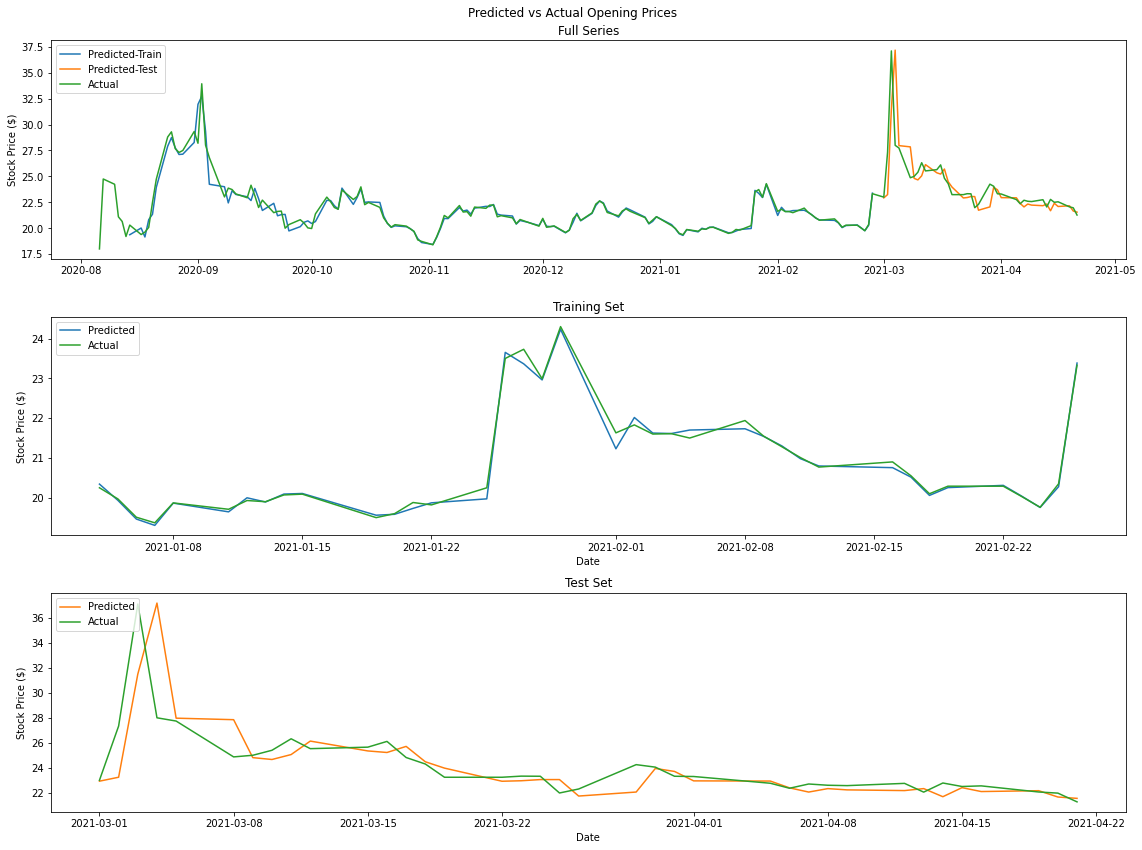

In [24]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [25]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,22.500000,-0.017959,Test,22.406879
2021-04-16,22.549999,-0.017096,Test,22.095915
2021-04-19,22.059999,-0.018202,Test,22.164479
2021-04-20,21.969999,-0.019107,Test,21.658463
2021-04-21,21.270000,-0.019384,Test,21.550214


In [26]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [27]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)